# Task 3: Fake News Detection

Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Load and Merge Dataset

In [2]:
df_fake = pd.read_csv('/content/Dataset/Fake.csv')
df_true = pd.read_csv('/content/Dataset/True.csv')

df_fake['text'] = df_fake['title'] + ' ' + df_fake['text']
df_true['text'] = df_true['title'] + ' ' + df_true['text']
df_fake['label'] = 'fake'
df_true['label'] = 'real'
df_fake = df_fake[['text', 'label']]
df_true = df_true[['text', 'label']]

df = pd.concat([df_fake, df_true], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Data loaded and merged successfully")
df.head()

✅ Data loaded and merged successfully


,text,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,fake
1,Trump drops Steve Bannon from National Securit...,real
2,Puerto Rico expects U.S. to lift Jones Act shi...,real
3,OOPS: Trump Just Accidentally Confirmed He Le...,fake
4,Donald Trump heads for Scotland to reopen a go...,real


Text Preprocessing

In [3]:
def preprocess_text(text):
    text = re.sub('<.*?>', '', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = word_tokenize(text)
    filtered_tokens = [t for t in tokens if t not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return ' '.join(lemmatized_tokens)

df['text_clean'] = df['text'].apply(preprocess_text)
print("✅ Text preprocessing complete")
df.head()

✅ Text preprocessing complete


,text,label,text_clean
0,Ben Stein Calls Out 9th Circuit Court: Committ...,fake,ben stein call th circuit court committed coup...
1,Trump drops Steve Bannon from National Securit...,real,trump drop steve bannon national security coun...
2,Puerto Rico expects U.S. to lift Jones Act shi...,real,puerto rico expects u lift jones act shipping ...
3,OOPS: Trump Just Accidentally Confirmed He Le...,fake,oops trump accidentally confirmed leaked israe...
4,Donald Trump heads for Scotland to reopen a go...,real,donald trump head scotland reopen golf resort ...


Label Distribution + BONUS WordCloud

/tmp/ipython-input-3168980243.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df, palette='Set2')


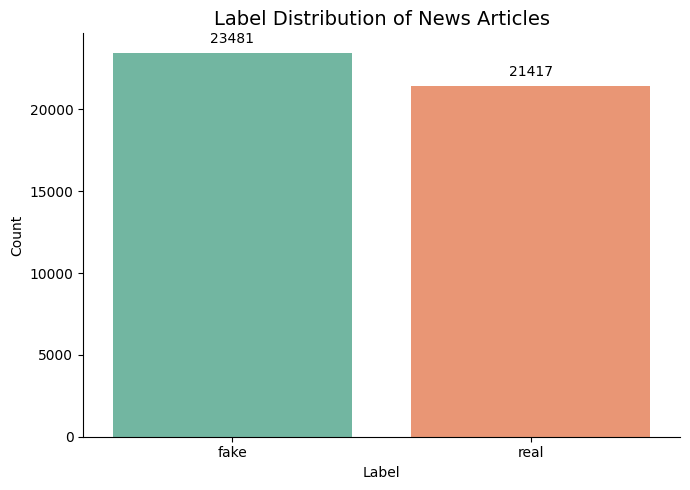

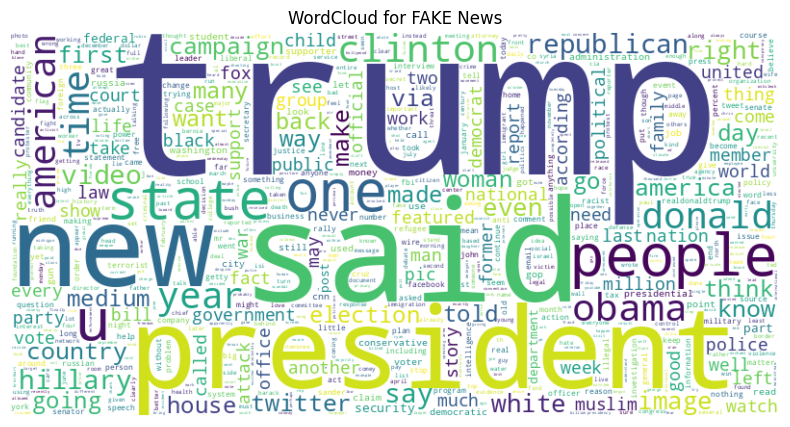

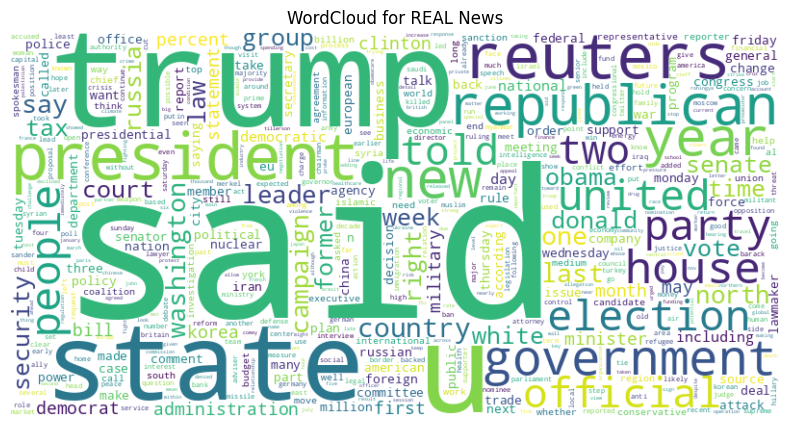

In [4]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='label', data=df, palette='Set2')
plt.title('Label Distribution of News Articles', fontsize=14)
plt.xlabel('Label')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
sns.despine()
plt.tight_layout()
plt.show()

#BONUS: WordCloud per Label
for label in df['label'].unique():
    sample = df[df['label'] == label].sample(min(2000, len(df[df['label'] == label])), random_state=42)
    text = ' '.join(sample['text_clean'])
    wc = WordCloud(width=800, height=400, background_color='white', max_words=2000, collocations=False).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {label.upper()} News')
    plt.show()

TF-IDF Vectorization

In [5]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['text_clean'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("TF-IDF vectorization done")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

✅ TF-IDF vectorization done
Train shape: (35918, 10000), Test shape: (8980, 10000)


Train Models (Logistic + SVM)

In [6]:
models = {}

# Logistic Regression
logreg = LogisticRegression(max_iter=1000, n_jobs=-1)
logreg.fit(X_train, y_train)
models['Logistic Regression'] = logreg

# SVM
from sklearn.linear_model import SGDClassifier
svm = SGDClassifier(loss='hinge', max_iter=1000, n_jobs=-1, random_state=42)
svm.fit(X_train, y_train)
models['SVM (Fast)'] = svm

print("Models trained successfully")

✅ Models trained successfully


Evaluation


Logistic Regression Results:
Accuracy: 0.99
              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      4710
        real       0.98      0.99      0.99      4270

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



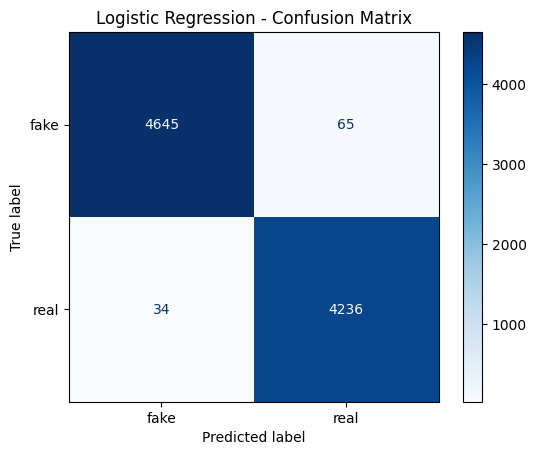


SVM (Fast) Results:
Accuracy: 0.99
              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      4710
        real       0.99      0.99      0.99      4270

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



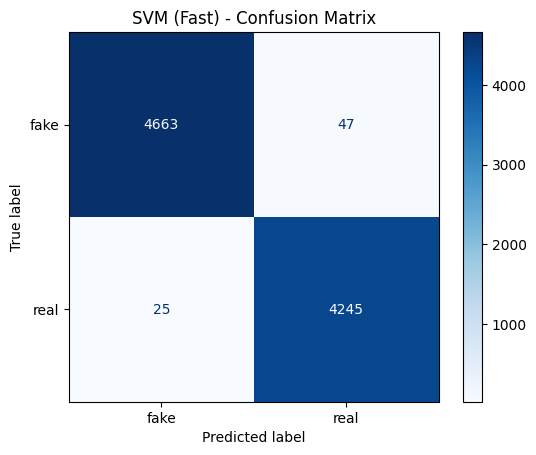

In [10]:
results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc # Store accuracy in results dictionary
    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.2f}")
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

Prediction Function

In [11]:
def predict_news_authenticity(input_text, model_choice='logistic'):
    text = preprocess_text(input_text)
    vect = vectorizer.transform([text])
    if model_choice.lower() == 'logistic':
        return logreg.predict(vect)[0]
    elif model_choice.lower() == 'svm':
        return svm.predict(vect)[0]
    else:
        raise ValueError("Model choice must be 'logistic' or 'svm'")

example = "The president announced new measures to improve the economy."
print(f"Predicted Label: {predict_news_authenticity(example, 'svm')}")

Predicted Label: fake


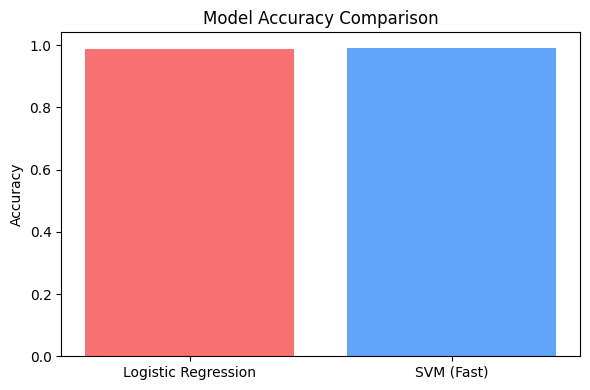

In [12]:
plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values(), color=['#f87171','#60a5fa','#4ade80'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

Save Models & Vectorizer

In [13]:
import os
os.makedirs('model', exist_ok=True)

with open('model/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('model/logistic_model.pkl', 'wb') as f:
    pickle.dump(logreg, f)

with open('model/svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)

print("All models and vectorizer saved successfully in /content/model/")


All models and vectorizer saved successfully in /content/model/
